# Qualitative Comparison HRNet

In previous work, we have shown how the HRNet model does not generalize well to images with the style of Greek vase paintings. In order to cope with this issue, we fine-tuned  the HRNet model with the Styled COCO data, thus obtaining much better quantitative results in terms of mAP.

In this notebook, we compare our improvements in a qualitatively manner. Hence, we predict the human poses using different checkpoints and we visualize the results to visually assess the improvements.

In [1]:
import os
import sys
from tqdm import tqdm

import numpy as np
import cv2
import torch
from torch.nn import DataParallel
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt

sys.path.append("..")

import models
import data
from data.data_loaders import load_dataset

import data.data_processing as data_processing
import lib.utils as utils
import lib.model_setup as model_setup
import lib.visualizations as visualizations
import lib.pose_parsing as pose_parsing
import lib.metrics as metrics
from data.custom_transforms import Normalize
from lib.loss import PersonMSELoss
from CONFIG import CONFIG
import CONSTANTS

In [2]:
exp_name = os.path.join("hrnet_tests", "styled_coco_augmented_epochs_150_lr_1e-3")
exp_path = os.path.join(CONFIG["paths"]["experiments_path"], exp_name)
data_path = CONFIG["paths"]["data_path"]
models_path = os.path.join(exp_path, "models")

exp_data = utils.load_experiment_parameters(exp_path)

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
pose_parsing.SKELETON = CONSTANTS.SKELETON_HRNET
data_processing.TO_COCO_MAP = CONSTANTS.COCO_MAP_HRNET
data_processing.SKIP_NECK = False

# 1. Loading Dataset and Sample Image

In this section, we fit a data loader with the Styled COCO validation set. Furthermore, we sample one image along with all its instances. This image will be used for the qualitative evaluation.

In [5]:
# loading validation dataset 
_, valid_loader, _, valid_set = load_dataset(exp_data, train=False, validation=True, shuffle_train=False,
                                             shuffle_valid=True, get_dataset=True)

Loading /home/corrales/MasterThesis/data/mapping_dicts/valid_dict.json...
loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [6]:
# sampling random image or loading given the id
# image_idx = np.random.randint(low=0, high=len(valid_set))
image_idx = 6253
image_name = valid_set.get_name_given_id(image_idx)
print(f"ID: {image_idx}  --  Image: {image_name}")

ID: 6253  --  Image: 000000343561_stylized_diomedes und aeneas.jpg


In [7]:
# sampling a person-crop and the annotatios  
imgs, target, target_weight, metadata = valid_set.get_all_samples_given_name(image_name)

n_humans = imgs.shape[0]
print(f"N People: {n_humans}")
original_img_path = metadata["original_image"][0]
original_img = cv2.imread(original_img_path, cv2.IMREAD_COLOR)
original_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
full_img_path = metadata["image"][0]
full_img = cv2.imread(full_img_path, cv2.IMREAD_COLOR)
full_img = cv2.cvtColor(full_img, cv2.COLOR_RGB2BGR)

N People: 11


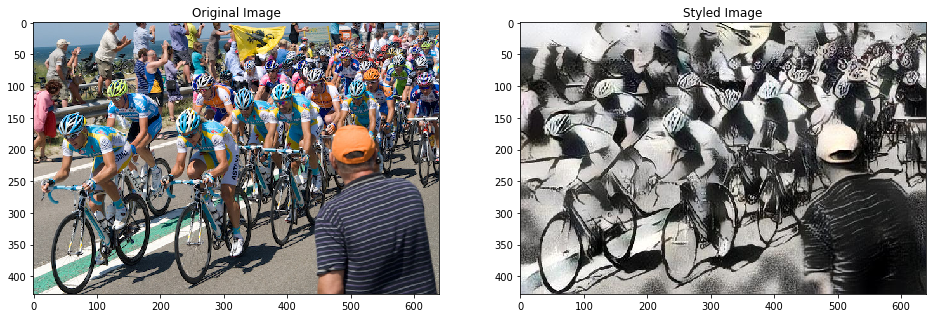

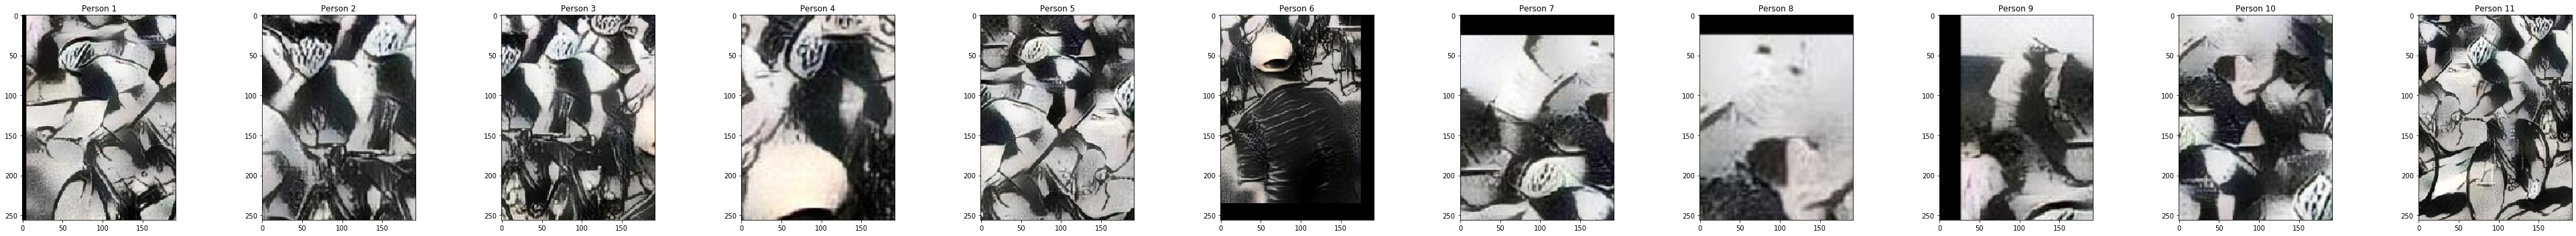

In [8]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,6)
visualizations.visualize_image(original_img, title="Original Image", ax=ax[0])
visualizations.visualize_image(full_img, title="Styled Image", ax=ax[1])
visualizations.visualize_instances(imgs)

# 2. Model Setup

In this second section, we instanciate an untuned HRNet model and a model skeleton to the fit with the precomputed weights. Furthermore, we initialize methods for computing loss and accuracy. This is not qualitative, but why not  :)

In [9]:
# HRNet Model instances
untrained_model = model_setup.load_model(exp_data)

In [10]:
# Some other interesting parameters
device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
imgs = imgs.to(device)
target = target.to(device)
target_weight = target_weight.to(device)
untrained_model.to(device)

loss_function = PersonMSELoss()
accuracy_function = lambda x,y: metrics.accuracy(x.cpu().detach().numpy(), y.cpu().numpy())[1]

In [11]:
def get_model_checkpoints(exp_path, n_checkpoints=5):
    """
    Obtaining the name of the checkpoints to evaluate
    
    Args:
    -----
    exp_path: string
        path to the root experiment directory
    n_checkpoints: integer
        number of intermediate checkpoints to load
    """
    
    checkpoints = sorted(os.listdir(os.path.join(exp_path, "models")))
    epochs = [int(c.split("_")[-1].split(".")[0]) for c in checkpoints]

    idx = np.argsort(epochs)
    epochs = [epochs[i] for i in idx]
    checkpoints = [checkpoints[i] for i in idx]

    trained_model = checkpoints[-1]
    n_models = len(checkpoints)-1
    interm_models = checkpoints[:-1][::(n_models//n_checkpoints)]
    
    return trained_model, interm_models

In [12]:
trained_model_pth, interm_models_pth = get_model_checkpoints(exp_path, n_checkpoints=5)
model_pths = interm_models_pth + [trained_model_pth]

In [13]:
model_names = ["checkpoint_untrained"] + [pth.split(".")[0] for pth in model_pths]
print(model_names)

['checkpoint_untrained', 'checkpoint_epoch_0', 'checkpoint_epoch_20', 'checkpoint_epoch_40', 'checkpoint_epoch_60', 'checkpoint_epoch_80', 'checkpoint_epoch_100']


# 3. Inference

Finally, we use each of the model checkpoints to predict the poses and to compute the loss and accuracy metrics for the particular image

In [14]:
untrained_output = untrained_model(imgs.float())
outputs = [untrained_output]
for model_pth in tqdm(model_pths):
    checkpoint_path = os.path.join(models_path, model_pth)
    model_skel = models.PoseHighResolutionNet(is_train=False)
    model_skel = DataParallel(model_skel).to(device)
    cur_model = model_setup.load_checkpoint(checkpoint_path, model_skel, only_model=True)
    cur_output = cur_model(imgs.float())
    outputs.append(cur_output)

100%|██████████| 6/6 [00:30<00:00,  5.03s/it]


In [15]:
print(f"       --Name--        --Loss--   --Acc--")
for i, name in enumerate(model_names):
    loss_value = loss_function(outputs[i], target, target_weight).item()
    acc_value = accuracy_function(outputs[i], target)
    print(f"{name}:   {round(loss_value,3)}      {round(100*acc_value,1)}%")

       --Name--        --Loss--   --Acc--
checkpoint_untrained:   0.002      16.4%
checkpoint_epoch_0:   0.002      28.7%
checkpoint_epoch_20:   0.002      35.5%
checkpoint_epoch_40:   0.002      35.6%
checkpoint_epoch_60:   0.002      36.2%
checkpoint_epoch_80:   0.002      36.2%
checkpoint_epoch_100:   0.002      36.2%


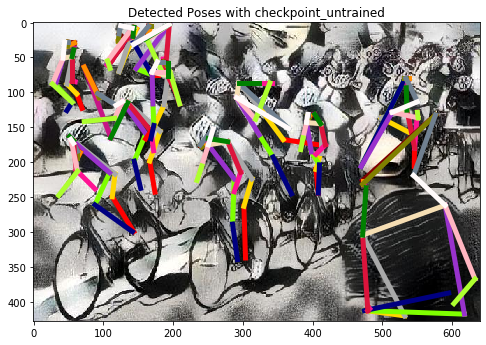

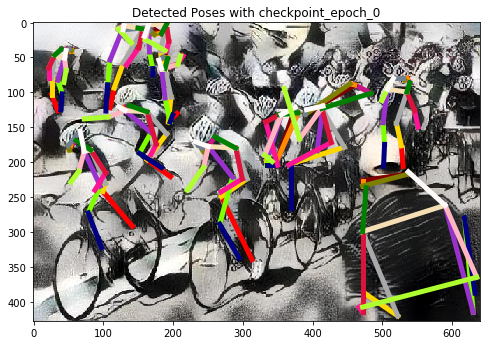

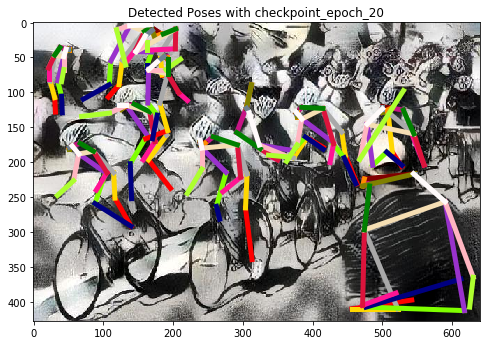

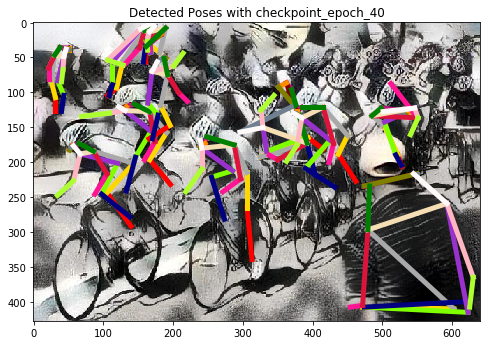

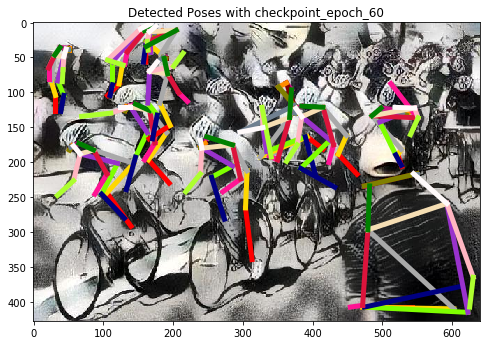

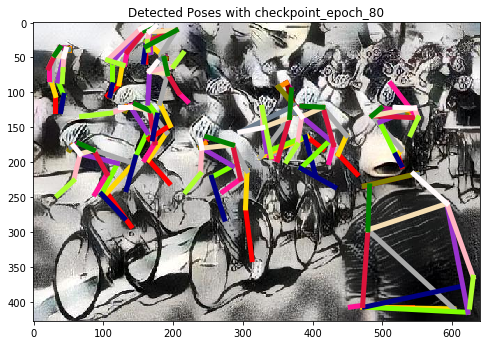

In [16]:
# pose parsing
centers = metadata["center"].numpy()
scales = metadata["scale"].numpy()
score = metadata["score"].numpy()

for i, output in enumerate(outputs):
    keypoints, max_vals, coords = pose_parsing.get_final_preds_hrnet(output.cpu().detach().numpy(), centers, scales)
    pose_entries, all_keypoints = pose_parsing.create_pose_entries(keypoints)

    all_keypoints = [all_keypoints[:, 1], all_keypoints[:, 0], all_keypoints[:, 2], all_keypoints[:, 3]]
    all_keypoints = np.array(all_keypoints).T

    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(8,6)

    title = f"Detected Poses with {model_names[i]}"
    visualizations.draw_pose(full_img, pose_entries, all_keypoints, ax=ax, title=title)

<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 